<a href="https://colab.research.google.com/github/marissafujimoto/catmap/blob/label-transfer-poc/notebooks/cancer_label_transfer_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Tabula Muris Tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/tabula_muris.html)

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scipy.io import mmread

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


Last run with scvi-tools version: 1.3.0


In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
nsclc_path = "/content/drive/MyDrive/catmap/Data/refquery_final_new.h5ad"

nsclc = sc.read(nsclc_path)

In [7]:
nsclc

AnnData object with n_obs × n_vars = 224611 × 72131
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2'
    var: 'features'
    obsm: 'X_umap', 'X_umap.ref'

In [8]:
nsclc.X[100, :].toarray()

array([[0.76055874, 5.03493207, 3.30350515, ..., 0.        , 0.        ,
        0.        ]])

In [9]:
# nsclc = nsclc[
#     (nsclc.obs.Subtype == "squamous cell carcinoma")
# ].copy()

In [10]:
nsclc.shape

(224611, 72131)

In [11]:
import gc

gc.collect()

11

In [12]:
raw_counts = mmread("/content/drive/MyDrive/catmap/Data/RNA_rawcounts_matrix.mtx")

In [13]:
raw_counts = raw_counts.T

In [14]:
raw_counts = raw_counts.tocsr()

In [15]:
raw_counts.shape

(224611, 72131)

In [16]:
nsclc.X.shape

(224611, 72131)

In [30]:
raw_counts[0, :].toarray()

array([[0., 7., 0., ..., 0., 0., 0.]])

In [23]:
nsclc.X = raw_counts

In [31]:
nsclc.X[0, :].toarray()

array([[0., 7., 0., ..., 0., 0., 0.]])

In [52]:
nsclc_train = nsclc[
    (nsclc.obs.Study != "GSE119911")
].copy()

nsclc_test = nsclc[
    (nsclc.obs.Study == "GSE119911")
].copy()

In [53]:
nsclc_train.X.shape

(223404, 72131)

In [54]:
nsclc_test.X.shape

(1207, 72131)

In [55]:
nsclc_train.X[0, :].toarray()

array([[0., 7., 0., ..., 0., 0., 0.]])

In [56]:
adata = nsclc_train
adata.layers["counts"] = adata.X.copy()
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="Study",
    subset=True,
)

In [63]:
np.sum(adata.X[0, :].toarray())

6346.0

In [57]:
scvi.model.SCVI.setup_anndata(adata, batch_key="Study")

In [58]:
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30)

In [64]:
scvi_model.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/36 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=36` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=36` reached.


In [65]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [66]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

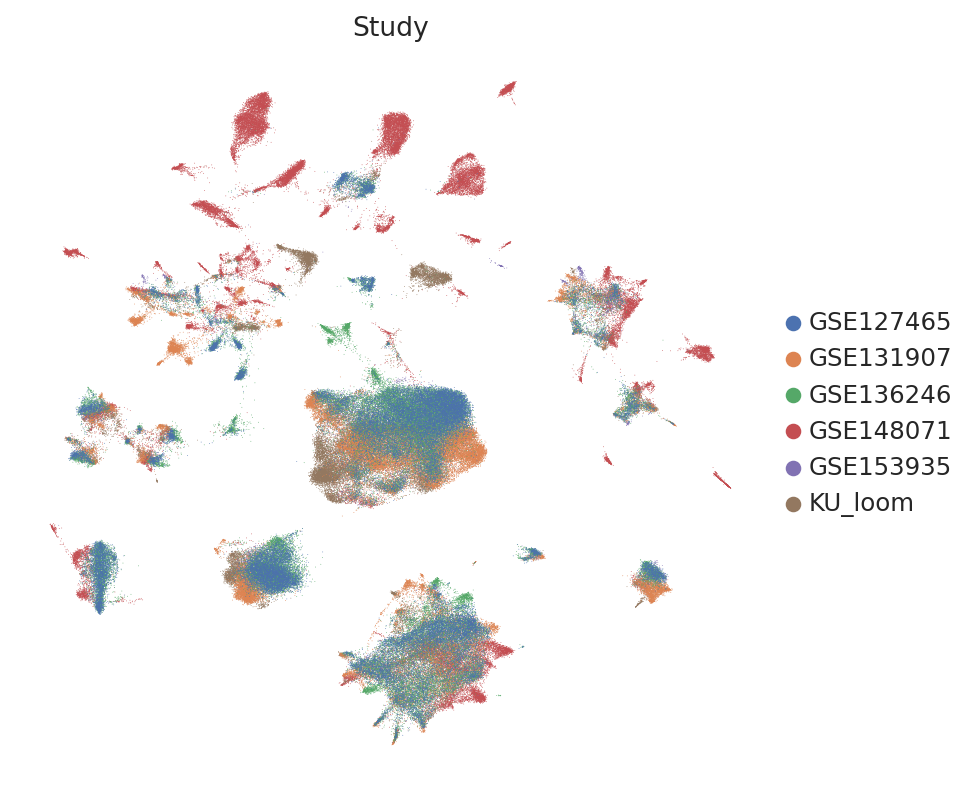

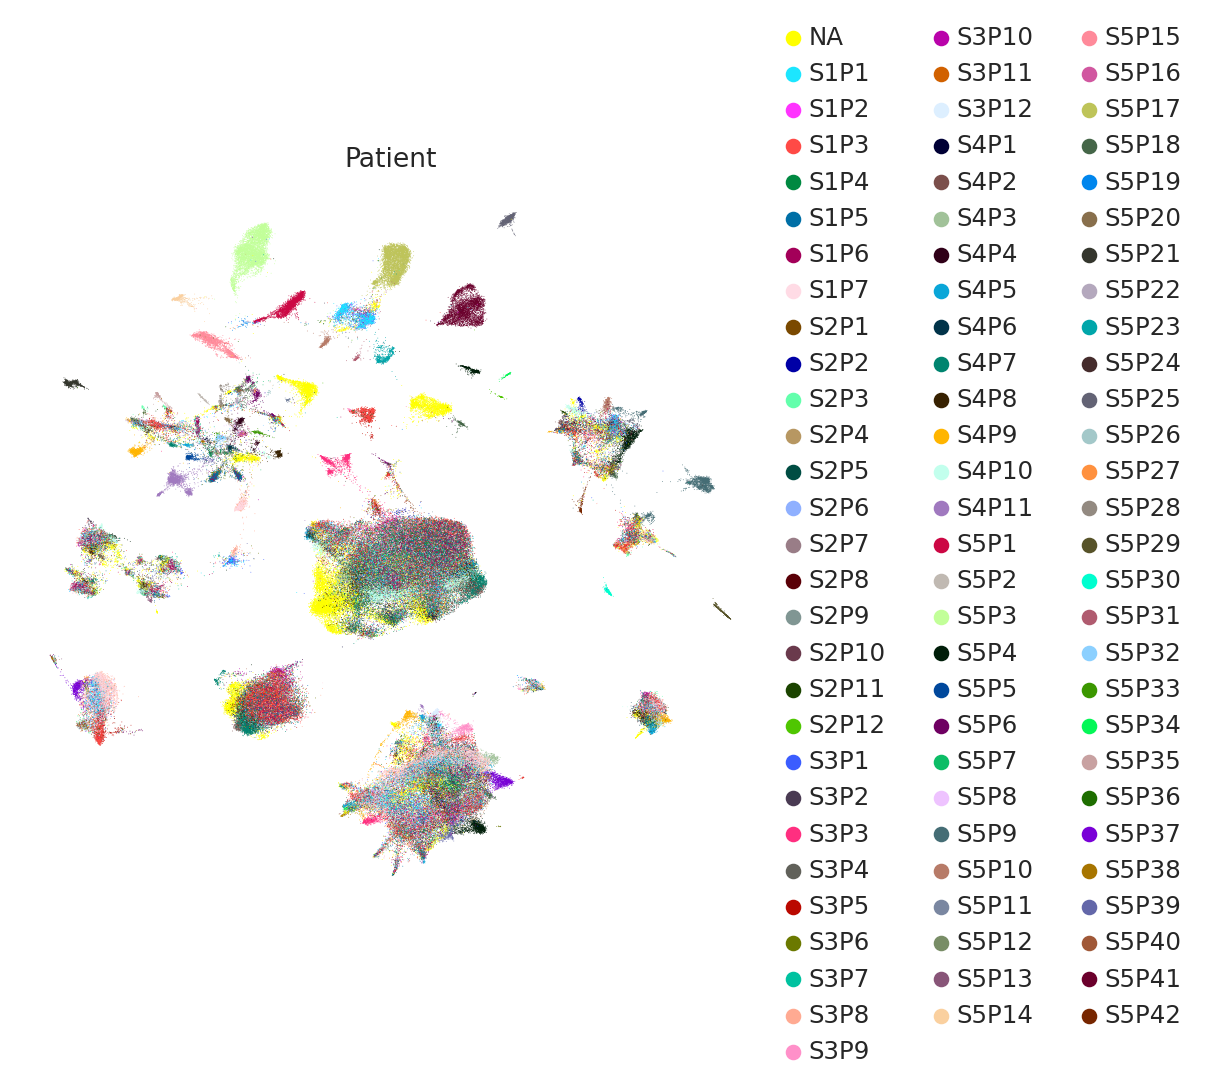

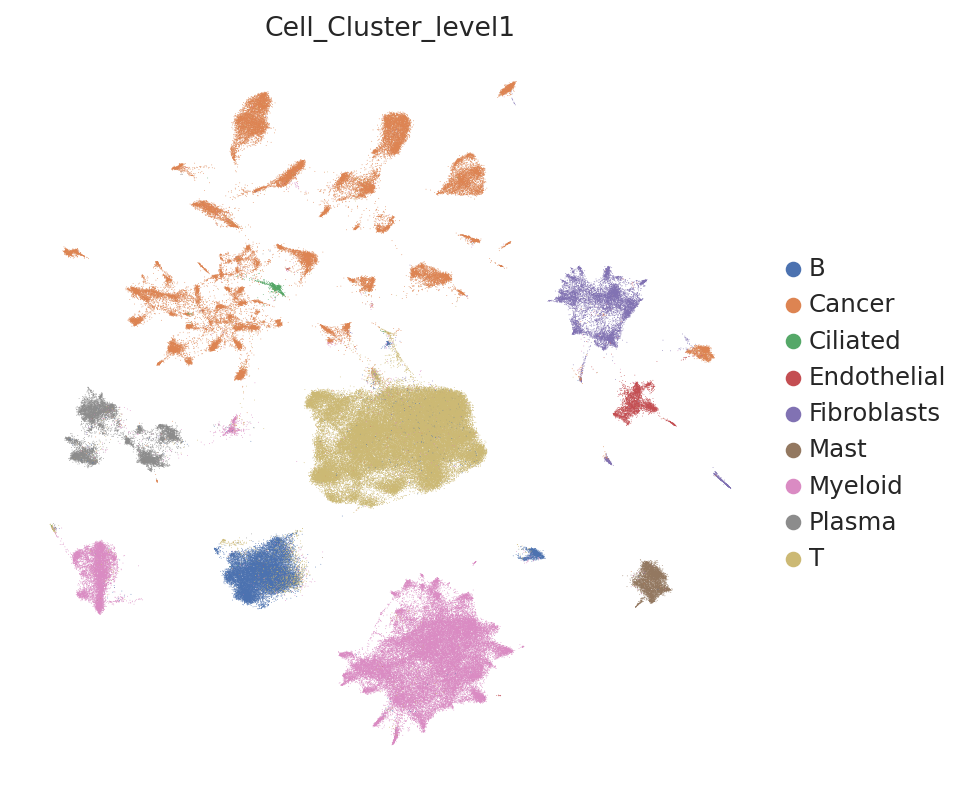

In [67]:
sc.pl.umap(
    adata,
    color=["Study"],
    frameon=False,
    ncols=1,
)
sc.pl.umap(
    adata,
    color=["Patient"],
    frameon=False,
    ncols=1,
)
sc.pl.umap(
    adata,
    color=["Cell_Cluster_level1"],
    frameon=False,
    ncols=1,
)


In [68]:
umap_df_test = pd.DataFrame(adata.obs['Study'], columns = ['Study'])
umap_df_test['Patient'] = adata.obs['Patient']
umap_df_test['Cell_Cluster_level1'] = adata.obs['Cell_Cluster_level1']
umap_df_test['Cell_Cluster_level2'] = adata.obs['Cell_Cluster_level2']
umap_df_test['Stage'] = adata.obs['Stage']
umap_df_test['UMAP1'] = adata.obsm['X_umap'][:, 0]
umap_df_test['UMAP2'] = adata.obsm['X_umap'][:, 1]

output_dir = "/content/drive/MyDrive/catmap"
os.makedirs(output_dir, exist_ok=True)

umap_df_test.to_csv(os.path.join(output_dir, 'umap_coordinates_labels_all_train.csv'), index=False)

## Transferring Labels: Preprocessing

We need to use the same normalizations and highly variable genes as the training data.

In [69]:
adata_transfer = nsclc_test.copy()
# sc.pp.normalize_total(adata_transfer, target_sum=1e4)
# sc.pp.log1p(adata_transfer)

In [70]:
adata

AnnData object with n_obs × n_vars = 223404 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2', '_scvi_batch', '_scvi_labels'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'Study_colors', 'Patient_colors', 'Cell_Cluster_level1_colors'
    obsm: 'X_umap', 'X_umap.ref', 'X_scVI'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [71]:
adata_transfer

AnnData object with n_obs × n_vars = 1207 × 72131
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2'
    var: 'features'
    obsm: 'X_umap', 'X_umap.ref'

In [72]:
highly_variable_train = set(adata.var["highly_variable"].index)
print(highly_variable_train)

{'SLN', 'TAGLN', 'MMP2', 'LINC01764', 'IGKV1-9', 'AC003682.1', 'IGLV9.49', 'CAV1', 'LINC02005', 'CCL22', 'AC131971.1', 'ALAS2', 'PRELP', 'D86994.2', 'TK1', 'MAOB', 'RP11-467L13.7', 'AC092756.1', 'LAMA4', 'ASCL1', 'IGHV1.69.2', 'HSPG2', 'ARL4C', 'IGHJ4', 'SAA1', 'HSPB1', 'ATAD2', 'A2ML1', 'GPR183', 'VCAN', 'SLAMF1', 'LUM', 'CD1A', 'COL1A2', 'OVAAL', 'RETN', 'C9orf116', 'CCDC102B', 'CDA', 'HP', 'TCP10L2', 'SPRR2E', 'IGFL2-AS1', 'NUP62', 'C20orf85', 'ELOVL4', 'KIR2DL3', 'SDF2L1', 'IGLV3-1', 'MYOM2', 'ITGBL1', 'TOLLIP.AS1', 'AC099654.1', 'IGLV2-14', 'UBD', 'PSORS1C2', 'RP11-626H12.2', 'FABP5', 'RBP5', 'TUBA3D', 'BX322234.2', 'DEFB4A', 'LIN28B', 'GABRD', 'AJ009632.1', 'SLC10A2', 'CCDC80', 'IGLV1-51', 'IL6', 'ADGRF1', 'COL10A1', 'AC026369.3', 'ESM1', 'TSPAN8', 'AC005730.3', 'VMO1', 'LINC00551', 'GZMA', 'XCL2', 'SCGB1D2', 'EDNRB', 'MYO6', 'IGLV1-36', 'TNC', 'ALDH3A1', 'CHIA', 'RP11-701P16.5', 'MMP19', 'C7', 'GDF15', 'MEDAG', 'AGER', 'SLC18A2', 'A2M', 'AC005005.4', 'IGLV3.21', 'MFAP4', 'CCL2',

In [73]:
adata_transfer

AnnData object with n_obs × n_vars = 1207 × 72131
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2'
    var: 'features'
    obsm: 'X_umap', 'X_umap.ref'

In [74]:
adata_transfer = adata_transfer[:, [i for i, feature in enumerate(adata_transfer.var.features) if feature in highly_variable_train]]

In [75]:
adata.layers["counts"]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 17506514 stored elements and shape (223404, 2000)>

In [77]:
adata_transfer.layers["counts"] = adata_transfer.X.copy()

<ipython-input-77-a749c61af14e>:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_transfer.layers["counts"] = adata_transfer.X.copy()


In [78]:
adata_transfer.layers["counts"]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 167127 stored elements and shape (1207, 2000)>

In [79]:
SCANVI_STAGE_KEY = "Stage"

adata_transfer.obs[SCANVI_STAGE_KEY] = "Unknown"
adata_transfer.obs["Study"] = "GSE127465" # hack to get around pretraining not recognizing batch
adata.obs["source"] = "train"
adata_transfer.obs["source"] = "test"

adata_concat = anndata.concat([adata, adata_transfer])

In [80]:
adata_concat

AnnData object with n_obs × n_vars = 224611 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2', 'source'
    obsm: 'X_umap', 'X_umap.ref'
    layers: 'counts'

In [81]:
np.unique(adata_concat.obs[SCANVI_STAGE_KEY], return_counts=True)

(array(['I', 'II', 'III', 'III/IV', 'IV', 'NA', 'Unknown'], dtype=object),
 array([53453, 18716, 41820, 51912, 16362, 41141,  1207]))

In [82]:
adata_concat.layers["counts"][-1, :].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [83]:
scvi_model.adata_manager.transfer_fields(adata_target=adata_concat, extend_categories=True)

In [84]:
scvi_model.adata_manager.view_registry()

Anndata setup with scvi-tools version 1.3.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Study',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   6    │
│         n_cells          │ 223404 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  2000  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Study'] │ GSE127465  │          0          │
│                    │ GSE131907  │          1          │
│                    │ GSE136246  │          2          │
│                    │ GSE148071  │          3          │
│                    │ GSE153935  │          4          │
│                    │  KU_loom   │          5          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [ ]:
# scanvi_model = scvi.model.SCANVI(adata_concat, n_layers=2, n_latent=30)

# scanvi_model.setup_anndata(adata_concat, layer="counts", labels_key=SCANVI_STAGE_KEY, unlabeled_category="Unknown", batch_key="Study")

# scvi_state_dict = scvi_model.module.state_dict()
# scanvi_model.module.load_state_dict(scvi_state_dict, strict=False)
# scanvi_model.was_pretrained = True

In [85]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata_concat,
    unlabeled_category="Unknown",
    labels_key=SCANVI_STAGE_KEY
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/lib/python3.11/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [86]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/scvi/module/_scanvae.py:305: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/dist-packages/scvi/module/_scanvae.py:305: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/dist-packages/scvi/module/_scanvae.py:305: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/dist-packages/scvi/module/_scanvae.py:305: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/dist-packages/scvi/module/_scanvae.py:305: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/dist-packages/scvi/module/_sc

In [87]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTION_KEY = "C_scANVI"

adata_concat.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata_concat)
adata_concat.obs[SCANVI_PREDICTION_KEY] = scanvi_model.predict(adata_concat)

In [88]:
sc.pp.neighbors(adata_concat, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata_concat, min_dist=0.3)

In [89]:
# in order to make colors matchup
adata_concat.obs.C_scANVI = pd.Categorical(
    adata_concat.obs.C_scANVI.values, categories=np.unique(adata_concat.obs.Stage)
)

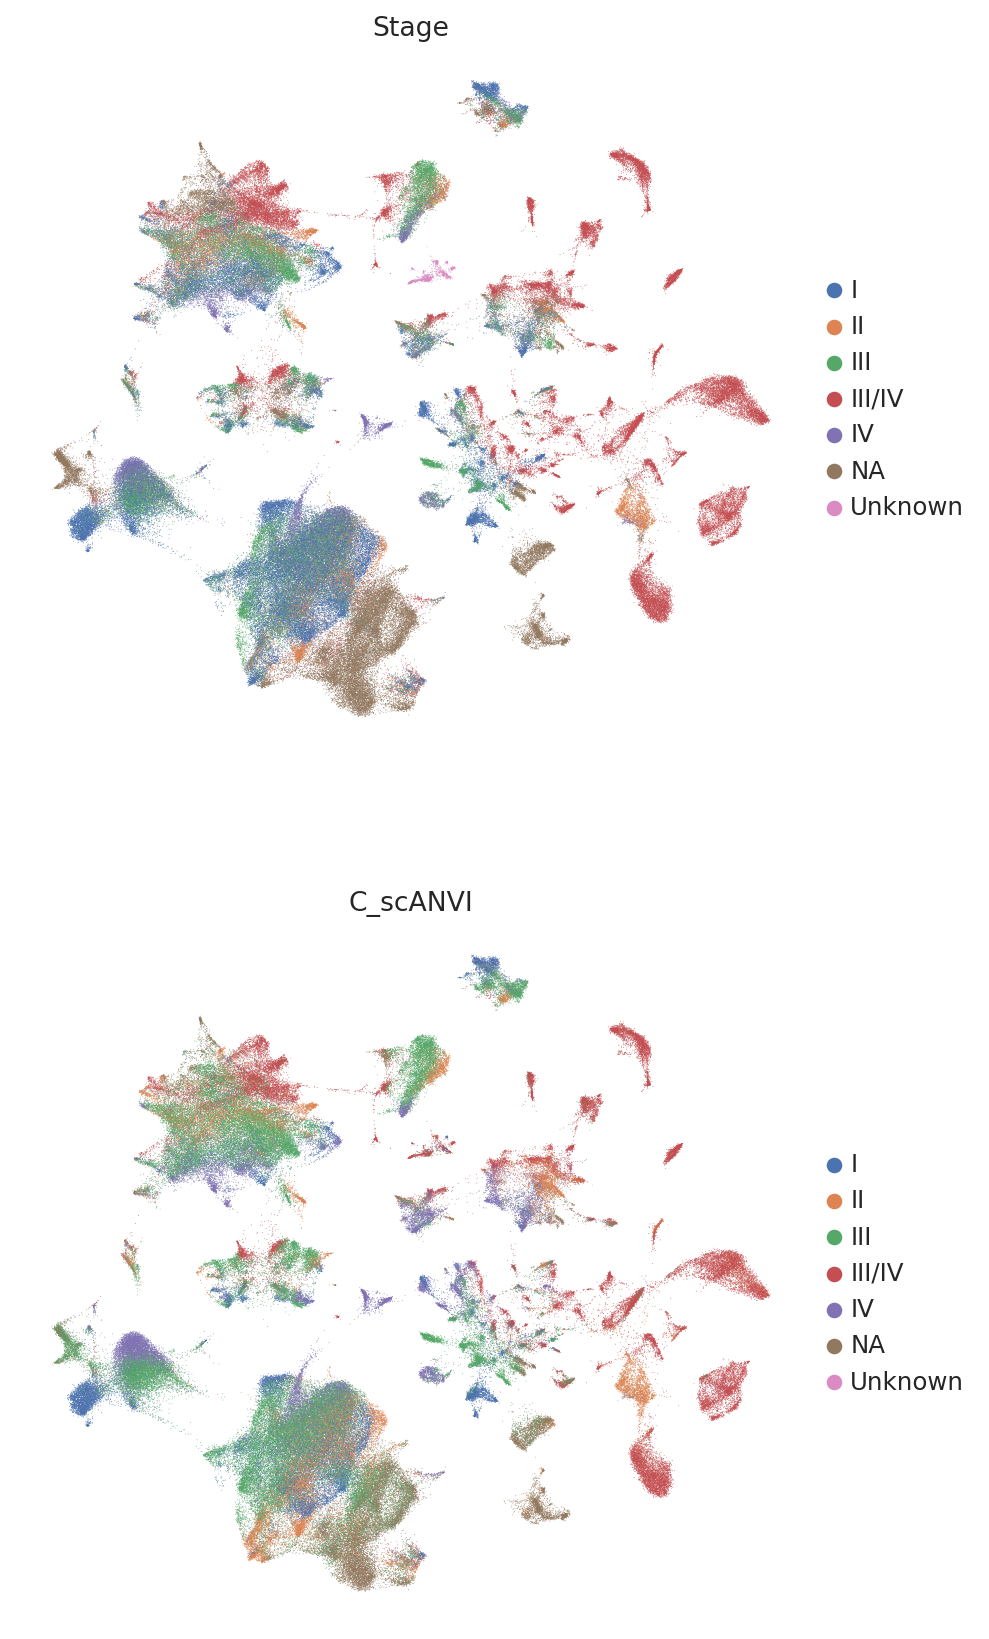

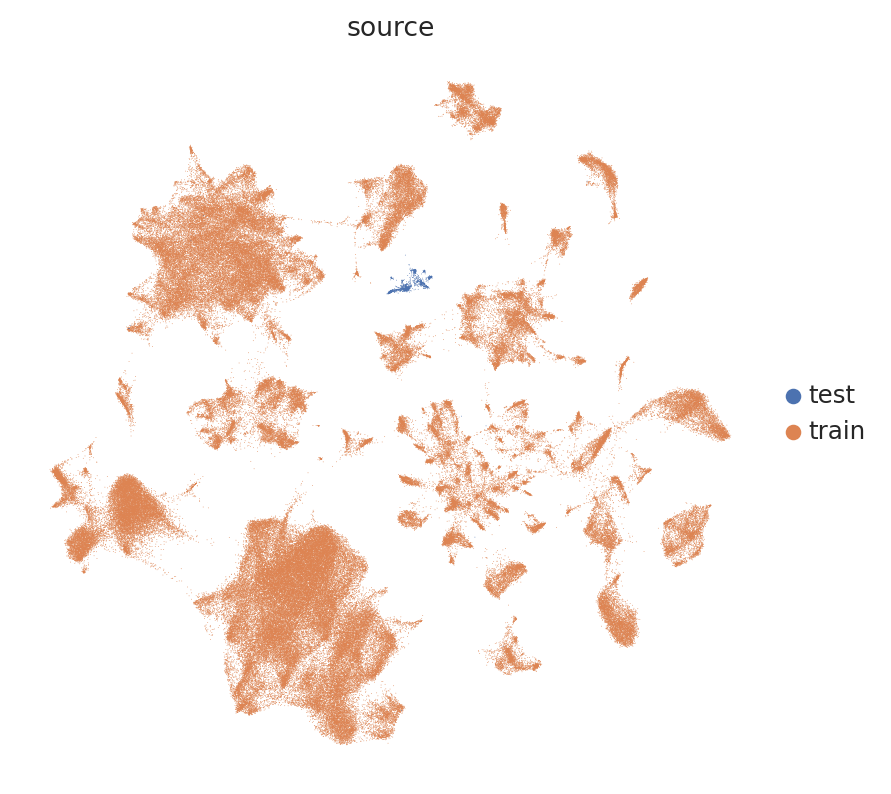

In [90]:
sc.pl.umap(
    adata_concat,
    color=["Stage", SCANVI_PREDICTION_KEY],
    frameon=False,
    ncols=1
)
sc.pl.umap(
    adata_concat,
    color=["source"],
    frameon=False,
    ncols=1,
)

In [91]:
df = adata_concat.obs.groupby(["Stage", SCANVI_PREDICTION_KEY]).size().unstack(fill_value=0)

<ipython-input-91-a577294a111c>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata_concat.obs.groupby(["Stage", SCANVI_PREDICTION_KEY]).size().unstack(fill_value=0)


In [92]:
conf_mat = df / df.sum(axis=1).values[:, np.newaxis]

Text(0, 0.5, 'Observed')

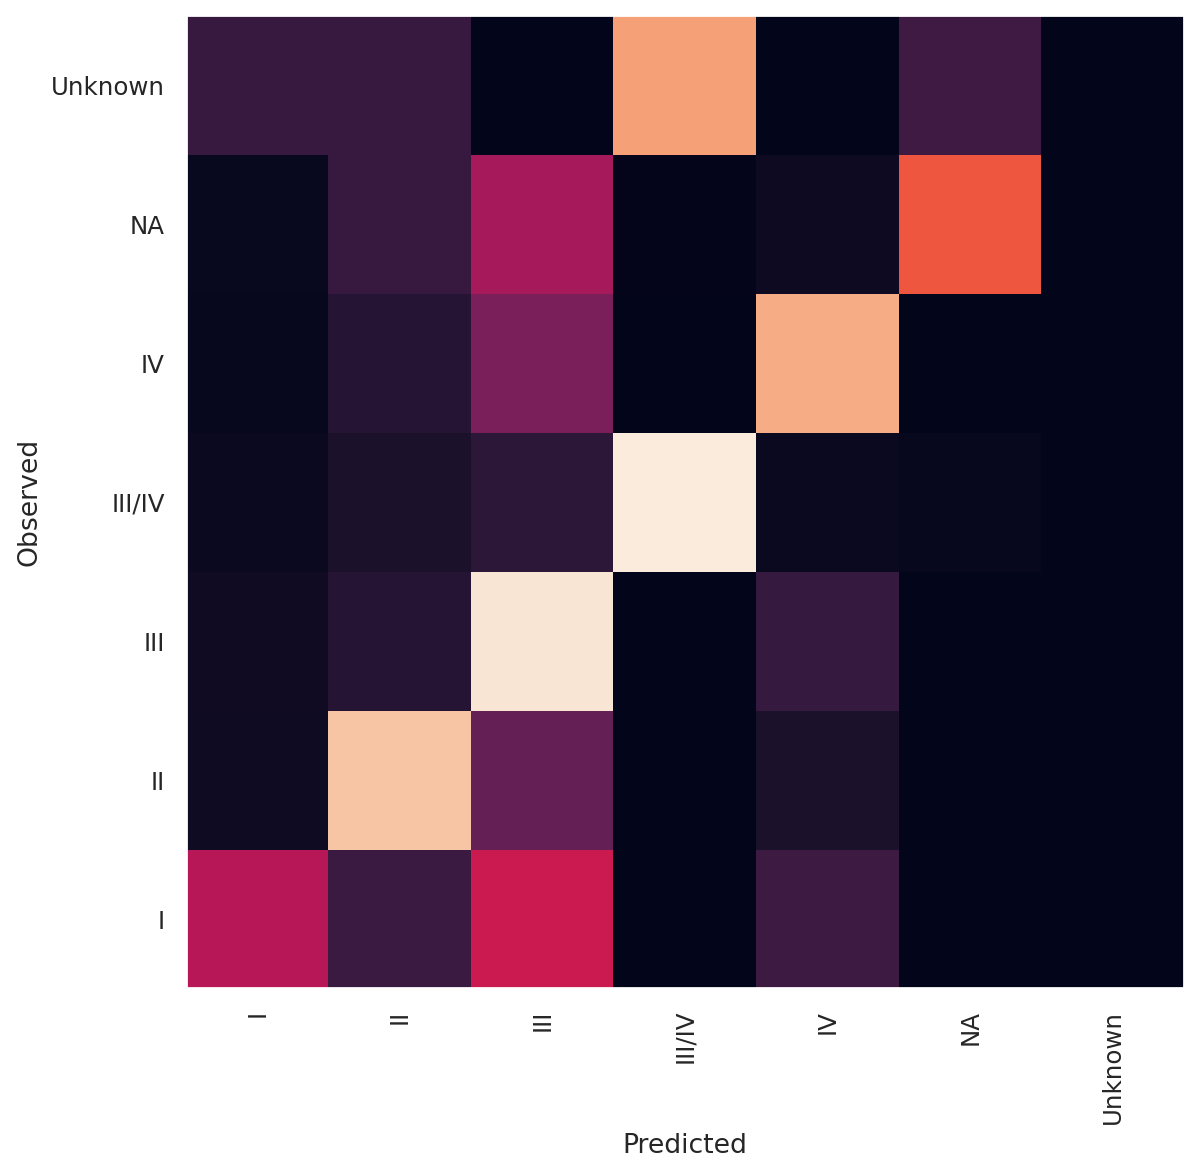

In [93]:
plt.figure(figsize=(8, 8))
_ = plt.pcolor(conf_mat)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

In [95]:
scvi_model.save(os.path.join(output_dir, "nsclc-scvi-model"))

In [99]:
adata.raw = None

In [100]:
adata.write(os.path.join(output_dir, "adata-train.h5ad"))

In [102]:
adata_transfer.raw = None

In [103]:
adata_transfer.write(os.path.join(output_dir, "adata-test.h5ad"))

In [104]:
adata_load = sc.read(os.path.join(output_dir, "adata-train.h5ad"))

In [105]:
adata_load

AnnData object with n_obs × n_vars = 223404 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2', '_scvi_batch', '_scvi_labels', 'source'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Cell_Cluster_level1_colors', 'Patient_colors', 'Study_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', 'X_umap.ref'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [106]:
adata

AnnData object with n_obs × n_vars = 223404 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2', '_scvi_batch', '_scvi_labels', 'source'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'Study_colors', 'Patient_colors', 'Cell_Cluster_level1_colors'
    obsm: 'X_umap', 'X_umap.ref', 'X_scVI'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [107]:
adata_transfer_load = sc.read(os.path.join(output_dir, "adata-train.h5ad"))

In [108]:
adata_transfer_load

AnnData object with n_obs × n_vars = 223404 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2', '_scvi_batch', '_scvi_labels', 'source'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Cell_Cluster_level1_colors', 'Patient_colors', 'Study_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', 'X_umap.ref'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [109]:
adata_transfer

AnnData object with n_obs × n_vars = 1207 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent_mt', 'Patient', 'Gender', 'Subtype', 'Stage', 'seurat_clusters', 'Study', 'Cell_Cluster_level1', 'Cell_Cluster_level2', 'validation_original_annotation', 'id', 'predicted.celltypel1.score', 'predicted.celltypel1', 'predicted.celltypel2.score', 'predicted.celltypel2', 'source'
    var: 'features'
    obsm: 'X_umap', 'X_umap.ref'
    layers: 'counts'

In [110]:
scvi_model_load = scvi.model.SCVI.load(os.path.join(output_dir, "nsclc-scvi-model"), adata_load)

INFO     File /content/drive/MyDrive/catmap/nsclc-scvi-model/model.pt already downloaded                           


In [111]:
scvi_model_load_transfer = scvi.model.SCVI.load(os.path.join(output_dir, "nsclc-scvi-model"), adata_transfer)

INFO     File /content/drive/MyDrive/catmap/nsclc-scvi-model/model.pt already downloaded                           


/usr/local/lib/python3.11/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
